## 파일 불러오기

In [1]:
import MeCab
m = MeCab.Tagger()

In [2]:
import pandas as pd

train_data = pd.read_csv('ratings_train.txt',sep='\t')
test_data = pd.read_csv('ratings_test.txt',sep='\t')

train_data = train_data.dropna(axis=0).reset_index(drop=True)
test_data = test_data.dropna(axis=0).reset_index(drop=True)

In [3]:
train_data['document'] = train_data['document'].apply(lambda x : x.replace('.',' '))
test_data['document'] = test_data['document'].apply(lambda x : x.replace('.',' '))

In [4]:
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
train_data['document'].nunique(), train_data['label'].nunique()

(146168, 2)

In [7]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [8]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

## 전처리

In [9]:
test_data.drop_duplicates(subset = ['document'], inplace=True)

In [10]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [11]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [12]:
from tqdm.notebook import tqdm

In [13]:
from konlpy.tag import Mecab

In [14]:
mecab = Mecab(dicpath='C:\mecab\mecab-ko-dic')

In [15]:
X_train = []
X_test = []
for i in tqdm(range(len(train_data))):
    sentence = [token[0] for token in mecab.pos(train_data['document'].iloc[i])]
    X_train.append([word for word in sentence if not word in stopwords])
    
for i in tqdm(range(len(test_data))):
    sentence = [token[0] for token in mecab.pos(test_data['document'].iloc[i])]
    X_test.append([word for word in sentence if not word in stopwords])
    

## Mecab

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_ = X_train.copy()
word_index =  tokenizer.word_index

In [18]:
tokenizer = Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(X_test)
X_test_ = X_test.copy()
word_index =  tokenizer.word_index

In [19]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
print(X_train[:3])

[[25, 63, 923, 27, 198, 13, 28, 646], [1111, 511, 515, 620, 2, 113, 1266, 44, 915, 972, 9, 39, 350], [17, 193, 1]]


In [21]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [22]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_train.shape, y_train.shape

((145368,), (145368,))

In [23]:
vocab_size = len(word_index) + 1
embedding_dim = 300
max_length = 100
truct_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [24]:
X_train =pad_sequences(X_train,maxlen = max_length, padding=padding_type)
X_test = pad_sequences(X_test,maxlen = max_length, padding=padding_type)

In [25]:
len(X_train), len(X_test)

(145368, 49154)

## Word2Vec

In [26]:
from gensim.models import Word2Vec

word2vec = Word2Vec(
    sentences = X_train_,
    size = 300, #임베딩 된 벡터 차원
    min_count = 2,
    window= 3, #컨텍스트 윈도우 사이즈
    sg = 1, # skip_gram
    iter = 10
)

In [27]:
word_vectors = word2vec.wv
word_vectors.vectors.shape

(28547, 300)

In [28]:
import numpy as np

embedding_matrix = np.zeros((vocab_size, embedding_dim))

# tokenizer에 있는 단어 사전을 순회하면서 word2vec의 300차원 vector를 가져옵니다
for word, idx in tokenizer.word_index.items():
    embedding_vector = word2vec[word] if word in word2vec else None
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
embedding_matrix.shape

C:\Users\DOYEON\anaconda3\envs\mulcam_b\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
C:\Users\DOYEON\anaconda3\envs\mulcam_b\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


(30066, 300)

## 모델1 Mecab_contextual
#### Train Accuracy:  0.8688
#### Test Accuracy:0.8338

In [77]:
from sklearn.utils import class_weight

In [90]:
from tensorflow.keras.preprocessing.text import Tokenizer 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, layers
from keras.models import load_model
from keras.regularizers import l2

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_length,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=max_length,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_mb_3 = keras.models.Model(sequence_input, output)
model_mb_3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model_mb_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          9019800   
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1806      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 9,021,613
Trainable params: 9,021,613
Non-trainable params: 0
_________________________________________________________________


In [91]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')

history_mb_3 = model_mb_3.fit(X_train, y_train,class_weight = class_weights_d, epochs=10, callbacks=[callback], batch_size=50, validation_split=0.2)

loss, accuracy = model_mb_3.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_mb_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
2326/2326 [==============================] - 363s 156ms/step - loss: 0.3257 - accuracy: 0.8625 - val_loss: 0.3656 - val_accuracy: 0.8412
Epoch 2/10
4543/4543 [==============================] - 22s 5ms/step - loss: 0.3107 - accuracy: 0.8688
Training Accuracy: 0.8688
Testing Accuracy:  0.8338


### ACC, LOSS 그래프

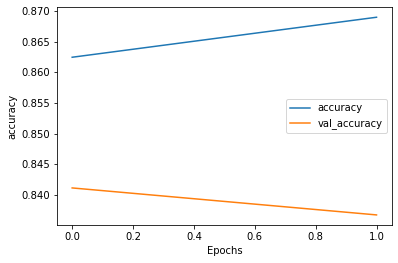

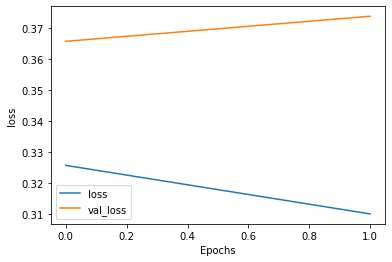

In [92]:
import matplotlib.pyplot as plt

def plot_graphs(history_mb_3, string):
  plt.plot(history_mb_3.history[string])
  plt.plot(history_mb_3.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_mb_3, 'accuracy')
plot_graphs(history_mb_3, 'loss')

### 예측

In [93]:
new_sentence = '경제가 어렵다고 하지만 이런 것에도 88억을 쓰는데'
new_sentence = [token[0] for token in mecab.pos(new_sentence)]
new_sentence = [word for word in new_sentence if not word in stopwords] 
encoded = tokenizer.texts_to_sequences([new_sentence])
pad_new = pad_sequences(encoded, maxlen = max_length)
score = float(model_mb_3.predict(pad_new))

if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

91.61% 확률로 부정 리뷰입니다.



In [94]:
new_sentence = '깔게없는영화'
new_sentence = [token[0] for token in mecab.pos(new_sentence)]
new_sentence = [word for word in new_sentence if not word in stopwords]
encoded = tokenizer.texts_to_sequences([new_sentence])
pad_new = pad_sequences(encoded, maxlen = max_length) 
score = float(model_mb_3.predict(pad_new))

if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

80.00% 확률로 부정 리뷰입니다.



In [95]:
new_sentence = '아직 못 본 사람 부럽다. 소름 돋을 수 있어서...처음 봤을 때 그 전율을 다시 한번 느끼고싶다.'
new_sentence = [token[0] for token in mecab.pos(new_sentence)] 
new_sentence = [word for word in new_sentence if not word in stopwords] 
encoded = tokenizer.texts_to_sequences([new_sentence]) 
pad_new = pad_sequences(encoded, maxlen = max_length)
score = float(model_mb_3.predict(pad_new))

if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

98.61% 확률로 긍정 리뷰입니다.



In [96]:
# Mecab_Contextual
model_mb_3.save('model_1')

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


## 모델2 Mecab_Static
#### Train Accuracy: 0.8684
#### Test Accuracy: 0.8499

In [70]:
import subprocess

with open('wiki.ko.vec', encoding='utf-8') as f:
    wiki = f.readlines()

In [72]:
embedding_dict = dict()

for line in tqdm(wiki):
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') 
    embedding_dict[word] = word_vector_arr
# f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))


879130개의 Embedding vector가 있습니다.


In [73]:
# 임베딩 메트릭스
embedding_matrix = np.zeros((vocab_size , embedding_dim))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)
out_index = 0
for word, i in word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
  try:
    embedding_vector = word2vec.wv.__getitem__(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        out_index += 1
  except:
    out_index +=1

print(out_index)

9886


In [78]:
# Kim Yoon CNN
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_length,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=max_length,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)


C:\Users\DOYEON\anaconda3\envs\mulcam_b\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 1 0 ... 0 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [79]:
model_mb_1 = keras.models.Model(sequence_input, output)
model_mb_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_mb_1.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 300)     9019800     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 128)     115328      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 100, 128)     153728      embedding_4[0][0]                
_______________________________________________________________________________________

In [84]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')

history_mb_1 = model_mb_1.fit(X_train, y_train,
                    class_weight = class_weights_d,
                    epochs=10,
                    callbacks=[callback],
                    verbose=True,
                    validation_split=0.2,
                    batch_size=50)
loss, accuracy = model_mb_1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_mb_1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
2326/2326 [==============================] - 357s 153ms/step - loss: 0.3604 - accuracy: 0.8589 - val_loss: 0.3687 - val_accuracy: 0.8553
Epoch 2/10
4543/4543 [==============================] - 176s 39ms/step - loss: 0.3402 - accuracy: 0.8684s - l
Training Accuracy: 0.8684
Testing Accuracy:  0.8499


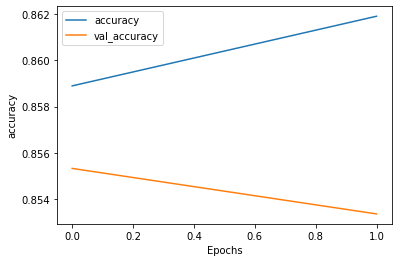

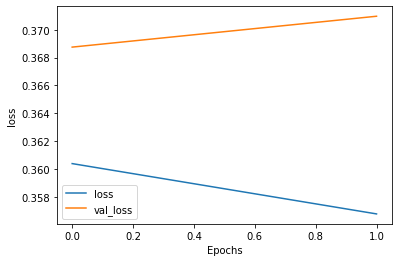

In [85]:
import matplotlib.pyplot as plt

def plot_graphs(history_mb_1, string):
  plt.plot(history_mb_1.history[string])
  plt.plot(history_mb_1.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_mb_1, 'accuracy')
plot_graphs(history_mb_1, 'loss')

### 예측

In [86]:
new_sentence = '경제가 어렵다고 하지만 이런 것에도 88억을 쓰는데'
new_sentence = [token[0] for token in mecab.pos(new_sentence)]
new_sentence = [word for word in new_sentence if not word in stopwords] 
encoded = tokenizer.texts_to_sequences([new_sentence])
pad_new = pad_sequences(encoded, maxlen = max_length)
score = float(model_mb_2.predict(pad_new))

if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

53.47% 확률로 부정 리뷰입니다.



In [87]:
new_sentence = '깔게없는영화'
new_sentence = [token[0] for token in mecab.pos(new_sentence)]
new_sentence = [word for word in new_sentence if not word in stopwords]
encoded = tokenizer.texts_to_sequences([new_sentence])
pad_new = pad_sequences(encoded, maxlen = max_length) 
score = float(model_mb_2.predict(pad_new))

if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

54.14% 확률로 부정 리뷰입니다.



In [88]:
new_sentence = '아직 못 본 사람 부럽다. 소름 돋을 수 있어서...처음 봤을 때 그 전율을 다시 한번 느끼고싶다.'
new_sentence = [token[0] for token in mecab.pos(new_sentence)] 
new_sentence = [word for word in new_sentence if not word in stopwords] 
encoded = tokenizer.texts_to_sequences([new_sentence]) 
pad_new = pad_sequences(encoded, maxlen = max_length)
score = float(model_mb_2.predict(pad_new))

if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

60.76% 확률로 긍정 리뷰입니다.



### 모델 저장

In [89]:
# Mecab_Static
model_mb_1.save('model_2')

INFO:tensorflow:Assets written to: model_2\assets


INFO:tensorflow:Assets written to: model_2\assets


## 모델3 Mecab_Non_Static
#### Training Accuracy: 0.8611
#### Testing Accuracy:  0.8430

In [97]:
from tensorflow.keras.preprocessing.text import Tokenizer 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, layers
from keras.models import load_model
from keras.regularizers import l2

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_d = dict(enumerate(class_weights))

sequence_input = Input(shape=(max_length,), dtype='int32')

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            weights=[embedding_matrix],
                                            input_length=max_length,
                                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = layers.Conv1D(128, fsz, activation='relu',padding='same',kernel_regularizer=l2(1e-3))(embedded_sequences)
    x = layers.MaxPooling1D()(x)
    convs.append(x)
    
x = layers.Concatenate(axis=-1)(convs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_mb_2 = keras.models.Model(sequence_input, output)
model_mb_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_mb_2.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 100, 300)     9019800     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 100, 128)     115328      embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 100, 128)     153728      embedding_6[0][0]                
_______________________________________________________________________________________

In [98]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=1, verbose=0, mode='auto')
history_mb_2 = model_mb_2.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    class_weight = class_weights_d,
                    callbacks=[callback],
                    validation_split=0.2,
                    batch_size=50)
loss, accuracy = model_mb_2.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_mb_2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/10
2326/2326 [==============================] - 339s 146ms/step - loss: 0.4552 - accuracy: 0.8308 - val_loss: 0.4023 - val_accuracy: 0.8419
Epoch 2/10
2326/2326 [==============================] - 336s 144ms/step - loss: 0.3882 - accuracy: 0.8481 - val_loss: 0.3876 - val_accuracy: 0.8468
Epoch 3/10
2326/2326 [==============================] - 335s 144ms/step - loss: 0.3736 - accuracy: 0.8544 - val_loss: 0.3724 - val_accuracy: 0.8529
Epoch 4/10
2326/2326 [==============================] - 366s 157ms/step - loss: 0.3653 - accuracy: 0.8569 - val_loss: 0.3693 - val_accuracy: 0.8505
Epoch 5/10
4543/4543 [==============================] - 158s 35ms/step - loss: 0.3516 - accuracy: 0.8611
Training Accuracy: 0.8611
Testing Accuracy:  0.8430


### ACC, LOSS 그래프

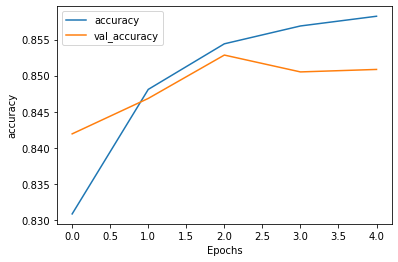

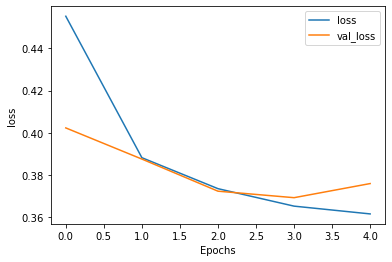

In [99]:
import matplotlib.pyplot as plt

def plot_graphs(history_mb_2, string):
  plt.plot(history_mb_2.history[string])
  plt.plot(history_mb_2.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_mb_2, 'accuracy')
plot_graphs(history_mb_2, 'loss')

### 예측

In [100]:
new_sentence = '경제가 어렵다고 하지만 이런 것에도 88억을 쓰는데'
new_sentence = [token[0] for token in mecab.pos(new_sentence)]
new_sentence = [word for word in new_sentence if not word in stopwords] 
encoded = tokenizer.texts_to_sequences([new_sentence])
pad_new = pad_sequences(encoded, maxlen = max_length)
score = float(model_mb_2.predict(pad_new))

if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

59.33% 확률로 긍정 리뷰입니다.



In [101]:
new_sentence = '깔게없는영화'
new_sentence = [token[0] for token in mecab.pos(new_sentence)]
new_sentence = [word for word in new_sentence if not word in stopwords]
encoded = tokenizer.texts_to_sequences([new_sentence])
pad_new = pad_sequences(encoded, maxlen = max_length) 
score = float(model_mb_2.predict(pad_new))

if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

56.24% 확률로 긍정 리뷰입니다.



In [102]:
new_sentence = '아직 못 본 사람 부럽다. 소름 돋을 수 있어서...처음 봤을 때 그 전율을 다시 한번 느끼고싶다.'
new_sentence = [token[0] for token in mecab.pos(new_sentence)] 
new_sentence = [word for word in new_sentence if not word in stopwords] 
encoded = tokenizer.texts_to_sequences([new_sentence]) 
pad_new = pad_sequences(encoded, maxlen = max_length)
score = float(model_mb_2.predict(pad_new))

if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

75.03% 확률로 긍정 리뷰입니다.



### 모델 저장

In [103]:
# Mecab_Non_Static
model_mb_2.save('model_3')

INFO:tensorflow:Assets written to: model_3\assets


INFO:tensorflow:Assets written to: model_3\assets
